Importation des librairies

In [42]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

# Configuration d'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')



Importation du csv autos.csv

In [48]:
#importation du csv
df = pd.read_csv("autos.csv", encoding='latin1')
# Liste des colonnes à supprimer
colonnes_a_supprimer = [
    'index', 
    'dateCrawled', 
    'name', 
    'seller', 
    'offerType', 
    'abtest', 
    'dateCreated', 
    'nrOfPictures', 
    'postalCode', 
    'lastSeen'
]

# Suppression des colonnes inutiles (inplace=True pour modifier df directement)
df.drop(columns=colonnes_a_supprimer, inplace=True)

# Afficher les colonnes restantes pour vérification
print("Colonnes restantes après nettoyage :", df.columns.tolist())
#f=df.drop(["index"])
# Taille du dataset
print(f" Jeu de données chargé : {df.shape[0]} lignes et {df.shape[1]} colonnes\n")

# Aperçu des 5 premières lignes
display(df.head())

# Types de données
print("\n🔎 Informations générales :")
print(df.info())


Colonnes restantes après nettoyage : ['price', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage']
 Jeu de données chargé : 371528 lignes et 11 colonnes



,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein



🔎 Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   price                371528 non-null  int64 
 1   vehicleType          333659 non-null  object
 2   yearOfRegistration   371528 non-null  int64 
 3   gearbox              351319 non-null  object
 4   powerPS              371528 non-null  int64 
 5   model                351044 non-null  object
 6   kilometer            371528 non-null  int64 
 7   monthOfRegistration  371528 non-null  int64 
 8   fuelType             338142 non-null  object
 9   brand                371528 non-null  object
 10  notRepairedDamage    299468 non-null  object
dtypes: int64(5), object(6)
memory usage: 31.2+ MB
None


Nettoyage des noms des colonnes

In [33]:

# On met les noms en minuscules, sans espaces, et avec underscores
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print("Noms de colonnes nettoyés :")
print(df.columns.tolist())


Noms de colonnes nettoyés :
['index', 'datecrawled', 'name', 'seller', 'offertype', 'price', 'abtest', 'vehicletype', 'yearofregistration', 'gearbox', 'powerps', 'model', 'kilometer', 'monthofregistration', 'fueltype', 'brand', 'notrepaireddamage', 'datecreated', 'nrofpictures', 'postalcode', 'lastseen']


In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# --- 0. Définition des Caractéristiques Clés ---
# Les noms de colonnes sont adaptés à la casse et au format de votre DataFrame nettoyé.
FEATURES = ['brand', 'yearofregistration', 'powerps', 'vehicletype', 'fueltype', 'gearbox']
TARGET = 'model'

# Remplacer les N/A des FEATURES par 'unknown' ou la médiane pour l'entraînement.
# Ceci est CRUCIAL car les modèles ML ne gèrent pas les N/A directement.
df['vehicletype'].fillna('unknown', inplace=True)
df['fueltype'].fillna('unknown', inplace=True)
df['gearbox'].fillna('unknown', inplace=True)

# Remplacer les N/A numériques par la médiane
df['powerps'].fillna(df['powerps'].median(), inplace=True)

# --- 1. Création du Dataset d'Entraînement/Prédiction ---

# L'ensemble d'entraînement contient les lignes où le modèle est connu
df_train = df.dropna(subset=[TARGET, 'brand']).copy()

# L'ensemble de prédiction contient les lignes où le modèle est manquant
df_predict = df[df[TARGET].isna()].copy()

print(f"Dataset à prédire (Modèle manquant) : {len(df_predict)} lignes")

if len(df_predict) == 0:
    print("✅ Aucun modèle manquant à imputer.")
else:
    # --- 2. Encodage des Variables ---
    
    # --- 2.1 Encodage de la Cible (y) ---
    le_model = LabelEncoder()
    df_train['model_encoded'] = le_model.fit_transform(df_train[TARGET])
    
    # --- 2.2 Encodage des Features (X) ---
    for feature in FEATURES:
        # On ne traite que les features catégorielles (object)
        if df[feature].dtype == 'object':
            le = LabelEncoder()
            
            # Entraîner l'encodeur sur l'ensemble complet des valeurs (train + predict)
            all_values = pd.concat([df_train[feature], df_predict[feature]]).astype(str).unique()
            le.fit(all_values)
            
            # Transformer les deux datasets
            df_train[feature + '_encoded'] = le.transform(df_train[feature].astype(str))
            df_predict[feature + '_encoded'] = le.transform(df_predict[feature].astype(str))
        
    # Définir les jeux de données X et Y pour le modèle
    X_cols = [f + '_encoded' if df[f].dtype == 'object' else f for f in FEATURES]
    X_train = df_train[X_cols]
    y_train = df_train['model_encoded']

    X_predict = df_predict[X_cols]

    # --- 3. Modélisation : Random Forest ---
    
    print("\nEntraînement du modèle Random Forest...")
    # Paramètres du Random Forest (n_estimators=150 pour la robustesse) 



    model = RandomForestClassifier(
        n_estimators=150,
        random_state=42, 
        n_jobs=-1,
        max_depth=20,
        min_samples_leaf=5
    )
    model.fit(X_train, y_train)

    # --- 4. Prédiction et Imputation Finale ---
    
    # Faire les prédictions
    predicted_model_labels = model.predict(X_predict)
    
    # Dé-encoder les prédictions pour obtenir les noms des modèles
    predicted_models = le_model.inverse_transform(predicted_model_labels)
    
    # !!! IMPUTATION DANS LE DATAFRAME df ORIGINAL !!!
    # On utilise l'index de df_predict pour imputer les valeurs au bon endroit dans df.
    df.loc[df_predict.index, TARGET] = predicted_models
    
    print(f"\n✅ Imputation réussie : {len(predicted_models)} modèles ont été prédits et imputés dans 'df'.")
    
    # Vérification finale
    print(f"Nouvelle quantité de modèles non-null : {df[TARGET].count()} / {len(df)}")

C:\Users\hugod\AppData\Local\Temp\ipykernel_20340\3654191198.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['vehicletype'].fillna('unknown', inplace=True)
C:\Users\hugod\AppData\Local\Temp\ipykernel_20340\3654191198.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

Dataset à prédire (Modèle manquant) : 20484 lignes

Entraînement du modèle Random Forest...

✅ Imputation réussie : 20484 modèles ont été prédits et imputés dans 'df'.
Nouvelle quantité de modèles non-null : 371528 / 371528


Supressions de potentiels doublons :

In [35]:

nb_doublons = df.duplicated().sum()
df = df.drop_duplicates()

print(f"Nombre de doublons supprimés : {nb_doublons}")
print(f"Nouvelle taille du dataset : {df.shape}")


Nombre de doublons supprimés : 0
Nouvelle taille du dataset : (371528, 21)


suppression des lignes sans modèle de véhicule (informations essentielles), puis remplace les valeurs manquantes : les colonnes textuelles reçoivent la valeur `"unknown"` et les colonnes numériques sont complétées par leur médiane. Cela garantit un jeu de données complet et exploitable.


In [36]:


# Comptage des valeurs manquantes
missing = df.isna().sum().sort_values(ascending=False)
print("Valeurs manquantes par colonne :\n", missing.head(10))

# Suppression des lignes sans modèle (car c'est une info essentielle)
if 'model' in df.columns:
    lignes_avant = df.shape[0]
    df = df.dropna(subset=['model'])
    print(f"\n Lignes supprimées car 'model' manquant : {lignes_avant - df.shape[0]}")

#suppression des lignes sans gearbox (feature trop importante)
if 'gearbox' in df.columns:
    lignes_avant = df.shape[0]
    df = df.dropna(subset=['gearbox'])
    print(f"Lignes supprimées car 'gearbox' manquant : {lignes_avant - df.shape[0]}")

print("Valeurs aberrantes et lignes incomplètes supprimées.")
print("Taille actuelle du dataset :", df.shape)

# Remplissage des valeurs manquantes pour certaines colonnes textuelles
for col in ['gearbox', 'fueltype', 'notrepaireddamage']:
    if col in df.columns:
        df[col] = df[col].fillna('unknown')

# Remplissage des colonnes numériques avec la médiane
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

print("\n Valeurs manquantes traitées.")


Valeurs manquantes par colonne :
 notrepaireddamage      72060
index                      0
model                      0
postalcode                 0
nrofpictures               0
datecreated                0
brand                      0
fueltype                   0
monthofregistration        0
kilometer                  0
dtype: int64

 Lignes supprimées car 'model' manquant : 0
Lignes supprimées car 'gearbox' manquant : 0
Valeurs aberrantes et lignes incomplètes supprimées.
Taille actuelle du dataset : (371528, 21)

 Valeurs manquantes traitées.


C:\Users\hugod\AppData\Local\Temp\ipykernel_20340\2823693959.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Filtrage des années et dans prix n'ayant aucun sens :

In [37]:


if 'price' in df.columns:
    df = df[(df['price'] > 100)]
# Filtrage des années hors bornes réalistes
if 'yearofregistration' in df.columns:
    df = df[(df['yearofregistration'] >= 1950) & (df['yearofregistration'] <= 2025)]

print("✅ Valeurs aberrantes supprimées.")
print("Taille actuelle du dataset :", df.shape)


✅ Valeurs aberrantes supprimées.
Taille actuelle du dataset : (356911, 21)


Conversion des dates :

In [38]:


date_cols = [c for c in df.columns if 'date' in c.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print("Colonnes de dates converties :", date_cols)


Colonnes de dates converties : ['datecrawled', 'datecreated']


In [39]:

print("Dimensions finales :", df.shape)
print("\nRésumé statistique :")
display(df.describe(include='all').T.head(10))
print(df.head())

df.to_csv("car_cleaned", index=False)


Dimensions finales : (356911, 21)

Résumé statistique :


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
index,356911.0,NaN,NaN,NaN,185782.86983,0.0,92872.0,185809.0,278658.5,371527.0,107255.824008
datecrawled,356911,NaN,NaN,NaN,2016-03-21 13:32:47.530285824,2016-03-05 14:06:22,2016-03-13 12:50:26.500000,2016-03-21 18:36:17,2016-03-29 14:52:50,2016-04-07 14:36:58,NaN
name,356911,221931,BMW_318i,627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller,356911,2,privat,356909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offertype,356911,2,Angebot,356905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,356911.0,NaN,NaN,NaN,17958.968505,101.0,1299.0,3100.0,7500.0,2147483647.0,3660646.931627
abtest,356911,2,test,184921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicletype,356911,9,limousine,93373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearofregistration,356911.0,NaN,NaN,NaN,2003.520976,1950.0,1999.0,2004.0,2008.0,2019.0,7.420664
gearbox,356911,3,manuell,265162,NaN,NaN,NaN,NaN,NaN,NaN,NaN


   index         datecrawled                            name  seller  \
0      0 2016-03-24 11:52:17                      Golf_3_1.6  privat   
1      1 2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   
2      2 2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   
3      3 2016-03-17 16:54:04             GOLF_4_1_4__3TÃRER  privat   
4      4 2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   

  offertype  price abtest vehicletype  yearofregistration    gearbox  powerps  \
0   Angebot    480   test     unknown                1993    manuell        0   
1   Angebot  18300   test       coupe                2011    manuell      190   
2   Angebot   9800   test         suv                2004  automatik      163   
3   Angebot   1500   test  kleinwagen                2001    manuell       75   
4   Angebot   3600   test  kleinwagen                2008    manuell       69   

   model  kilometer  monthofregistration fueltype       brand  \
0   golf     15

Rapide exploration des données afin d'obtenir quelques informations sur notre dataset :

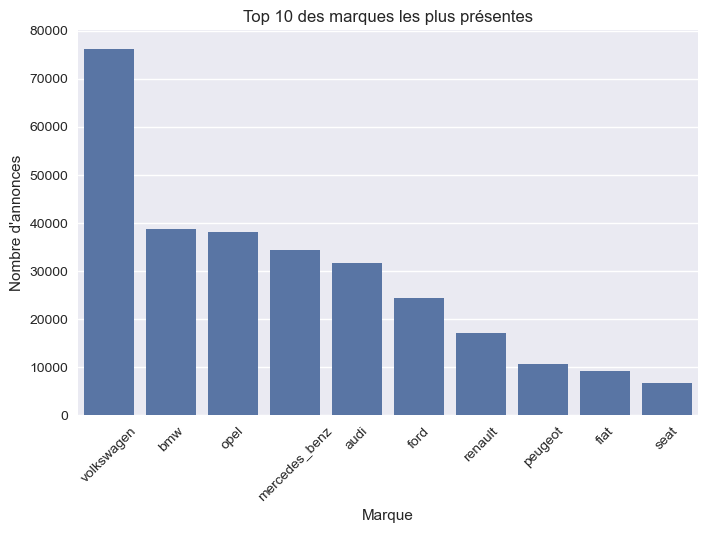

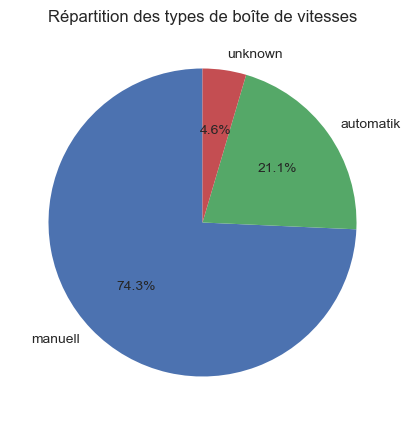

In [40]:
# Marques les plus fréquentes
if 'brand' in df.columns:
    plt.figure(figsize=(8,5))
    top_brands = df['brand'].value_counts().head(10)
    sns.barplot(x=top_brands.index, y=top_brands.values)
    plt.title("Top 10 des marques les plus présentes")
    plt.xlabel("Marque")
    plt.ylabel("Nombre d'annonces")
    plt.xticks(rotation=45)
    plt.show()

# Répartition des boîtes de vitesses
if 'gearbox' in df.columns:
    plt.figure(figsize=(5,5))
    df['gearbox'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title("Répartition des types de boîte de vitesses")
    plt.ylabel('')
    plt.show()


Exploration rapide des données :